In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer,AutoProcessor, BitsAndBytesConfig, get_scheduler,Gemma3ForConditionalGeneration
from bitsandbytes.optim import Adam8bit,PagedAdam32bit
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from peft import prepare_model_for_kbit_training
import torch
from IPython.display import  clear_output
import time
import gc
from torch.utils.data import Dataset, DataLoader
# import here opencv



# device_name = 'cuda:0' if cuda.is_available() else 'cpu'
# device = torch.device(device_name)

DEFAULT_MODEL = "google/gemma-3-4b-it"

bnb_config = BitsAndBytesConfig(
                                load_in_4bit=True,
                                bnb_4bit_use_double_quant=True,
                                bnb_4bit_quant_type='nf4',
                                bnb_4bit_compute_dtype=torch.bfloat16,
                                bnb_4bit_quant_storage=torch.bfloat16,
                                )


model = Gemma3ForConditionalGeneration.from_pretrained(
    DEFAULT_MODEL,
    quantization_config=bnb_config,
    attn_implementation='eager',
    device_map={'':torch.cuda.current_device()},
    torch_dtype=torch.bfloat16
    
)

print(model.get_memory_footprint()/(1024*1024)) 

tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL)

def flush():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()


2025-04-29 09:36:25.939805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745919385.949483 2141419 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745919385.952426 2141419 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 09:36:25.963251: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

3023.7419147491455


In [8]:
model.config.model_type

'gemma3'

# Load a Multi Lingual Dataset

In [2]:
from datasets import load_dataset

# Load the dataset
# dataset = load_dataset("OdiaGenAI/hardcode_odia_qa_105")
dataset = load_dataset('OdiaGenAI/odia_domain_context_train_v1')

In [3]:
dataset['train'][50]

{'instruction': 'ଓଡ଼ିଶାର ଉଦୟଗିରି ଏବଂ ଖଣ୍ଡଗିରି ଗୁମ୍ଫାର ଇତିହାସ କ’ଣ?',
 'input': '',
 'output': 'ଉଦୟଗିରି ଏବଂ ଖଣ୍ଡଗିରି ଗୁମ୍ଫା ଭାରତର ଓଡ଼ିଶା ରାଜ୍ୟରେ ଅବସ୍ଥିତ ପ୍ରାଚୀନ ଗୁମ୍ଫା ପରିସରର ଏକ ସମୂହ। ଏହି ଗୁମ୍ଫା ଗୁଡିକ ଖ୍ରୀଷ୍ଟପୂର୍ବ ଦ୍ୱିତୀୟ ଶତାବ୍ଦୀ ଏବଂ ପ୍ରଥମ ଶତାବ୍ଦୀ ମଧ୍ୟରେ ଜୈନ ସନ୍ନ୍ୟାସୀମାନଙ୍କ ଦ୍ୱାରା ବାଲୁକା ପଥରରେ ଖୋଦିତ ହୋଇଥିବା ଜଣାଯାଏ।\nଉଦୟଗିରି ଗୁମ୍ଫା ଗୁଡିକ ବୃହତ ଏବଂ ଅଧିକ ଜଟିଳ ହୋଇଥିବାବେଳେ ଖଣ୍ଡଗିରି ଗୁମ୍ଫା ଗୁଡିକ ଛୋଟ ଏବଂ ଡିଜାଇନ ଦୃଷ୍ଟିରୁ ସରଳ। ଏହି ପ୍ରାଚୀନ ଗୁମ୍ଫା ଗୁଡିକ ପ୍ରାଚୀନ ଭାରତୀୟ ସଭ୍ୟତାର ସ୍ଥାପତ୍ୟ କୌଶଳ ଏବଂ କଳାତ୍ମକ ଶ୍ରେଷ୍ଠତାର ପ୍ରମାଣ।\nବିଗତ ବର୍ଷମାନଙ୍କରେ ଏହି ଗୁମ୍ଫା ସାରା ବିଶ୍ୱରୁ ପର୍ଯ୍ୟଟକଙ୍କ ଆକର୍ଷଣ କେନ୍ଦ୍ର ପାଲଟିଛି ଏବଂ ଭାରତୀୟ ପ୍ରତ୍ନତାତ୍ୱିକ ସର୍ବେକ୍ଷଣ ଦ୍ୱାରା ସଂରକ୍ଷିତ ହୋଇଛି। ଭାରତର ସମୃଦ୍ଧ ସାଂସ୍କୃତିକ ଐତିହ୍ୟ ପ୍ରତି ଆଗ୍ରହୀ ଯେକୌଣସି ବ୍ୟକ୍ତି ଏହି ଗୁମ୍ଫାକୁ ଦେଖିବା ଉଚିତ।'}

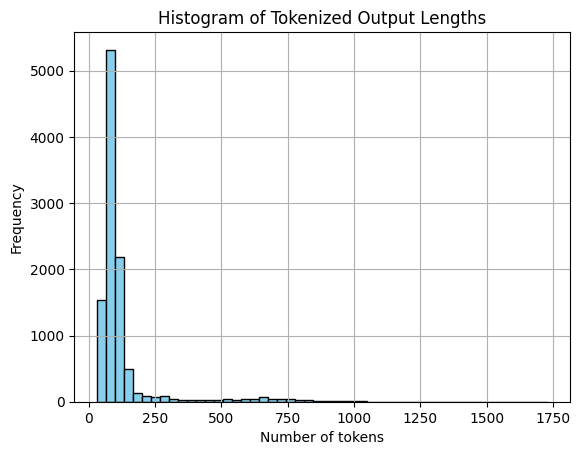

In [4]:
import matplotlib.pyplot as plt
lengths = [len(tokenizer(example['instruction']+ example['output'])['input_ids']) for example in dataset['train']]

# Plot the histogram
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Tokenized Output Lengths")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Automatic Training using TRL

In [ ]:
def create_conversation(sample):
  return {
    "messages": [
      # {"role": "system", "content": system_message},
      {"role": "user", "content": sample['instruction']},
      {"role": "assistant", "content": sample["output"]}
    ]
  }


# Convert dataset to OAI messages
dataset = dataset.map(create_conversation, remove_columns=['output','instruction','input'],batched=False)
# split dataset into 10,000 training samples and 2,500 test samples
# dataset = dataset.train_test_split(test_size=2500/12500)

# # Print formatted user prompt
# print(dataset["train"][345]["messages"][1]["content"])

Map:   0%|          | 0/10502 [00:00<?, ? examples/s]

In [ ]:
tokenizer.apply_chat_template(dataset['train'][0]['messages'],tokenize=False)

'<bos><start_of_turn>user\nଓଡ଼ିଶାର ଅର୍ଥନୀତି ଉପରେ ପର୍ଯ୍ୟଟନର କିଭଳି ପ୍ରଭାବ ପଡ଼ିଛି?<end_of_turn>\n<start_of_turn>model\nବିଗତ କିଛି ବର୍ଷ ମଧ୍ୟରେ ପର୍ଯ୍ୟଟନ ଶିଳ୍ପ ଦ୍ୱାରା ଓଡ଼ିଶାର ଅର୍ଥନୀତି ବ୍ୟାପକ ଭାବେ ପ୍ରଭାବିତ ହୋଇଛି। ରାଜ୍ୟରେ ପ୍ରାକୃତିକ ସୌନ୍ଦର୍ଯ୍ୟ ଏବଂ ସାଂସ୍କୃତିକ ଐତିହ୍ୟ ସ୍ଥାନ ରହିଛି, ଯାହା ଦେଶ ଏବଂ ଦେଶ ବାହାରର ପର୍ଯ୍ୟଟକଙ୍କ ପାଇଁ ଆକର୍ଷଣୀୟ ହୋଇପାରିଛି।\nପର୍ଯ୍ୟଟନ କ୍ଷେତ୍ରରେ କାର୍ଯ୍ୟ କରୁଥିବା ଲୋକମାନଙ୍କ ପାଇଁ ନିଯୁକ୍ତି ସୁଯୋଗ ଏବଂ ଆୟ ବୃଦ୍ଧି ପାଇଛି, ଯେଉଁଥିରେ ଆତିଥ୍ୟ, ଟୁର ଅପରେଟର ଏବଂ ପରିବହନ ଶିଳ୍ପ ସାମିଲ ରହିଛି। ପର୍ଯ୍ୟଟନ ଶିଳ୍ପ ସ୍ଥାନୀୟ ଖାଦ୍ୟ, ହସ୍ତଶିଳ୍ପ ଏବଂ ସାଂସ୍କୃତିକ ଗତିବିଧିକୁ ପ୍ରୋତ୍ସାହିତ କରିବାରେ ସହାୟତା କରିଛି, ଯାହାକି ଓଡ଼ିଶାର ସାମଗ୍ରିକ ଅର୍ଥନୀତି ଉପରେ ସକାରାତ୍ମକ ପ୍ରଭାବ ପକାଇଛି।\nପର୍ଯ୍ୟଟକମାନଙ୍କ ପାଇଁ ଉତ୍ତମ ଅନୁଭୂତି ସୁନିଶ୍ଚିତ କରିବା ପାଇଁ ଭିତ୍ତିଭୂମି ବିକାଶ ଉପରେ ମଧ୍ୟ ସରକାର ଗୁରୁତ୍ୱ ଦେଉଛନ୍ତି। ସଡ଼କ ଏବଂ ସାର୍ବଜନୀନ ପରିବହନ ବ୍ୟବସ୍ଥାରେ ସୁଧାର କରାଯାଇଛି, ଯେତେବେଳେ କି ରାଜ୍ୟର ଅନେକ କ୍ଷେତ୍ରରେ ବିଭିନ୍ନ ଇକୋ-ଟୁରିଜମ ପ୍ରକଳ୍ପର ବିକାଶ କରାଯାଇଛି।\nଶେଷରେ ପର୍ଯ୍ୟଟନ ଓଡ଼ିଶାର ଆର୍ଥିକ ବିକାଶକୁ ତ୍ୱରାନ୍ୱିତ କରିବାରେ ଗୁରୁତ୍ୱପୂର୍ଣ୍ଣ ଭୂମିକା ନିର୍ବାହ କରିଛି ଏବଂ ରାଜ୍ୟବାସୀଙ୍କ ପାଇଁ ଅନେକ ଲାଭ 

In [7]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=["lm_head", "embed_tokens"] # make sure to save the lm_head and embed_tokens as you train the special tokens
)

In [9]:
from trl import SFTConfig
torch_dtype = torch.bfloat16
args = SFTConfig(
    output_dir="gemma-text-to-sql",         # directory to save and repository id
    max_seq_length=512,                     # max sequence length for model and packing of the dataset
    packing=True,                           # Groups multiple samples in the dataset into a single sequence
    num_train_epochs=3,                     # number of training epochs
    per_device_train_batch_size=1,          # batch size per device during training
    gradient_accumulation_steps=4,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=10,                       # log every 10 steps
    save_strategy="epoch",                  # save checkpoint every epoch
    learning_rate=2e-4,                     # learning rate, based on QLoRA paper
    fp16=True if torch_dtype == torch.float16 else False,   # use float16 precision
    bf16=True if torch_dtype == torch.bfloat16 else False,   # use bfloat16 precision
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    push_to_hub=True,                       # push model to hub
    report_to="tensorboard",                # report metrics to tensorboard
    dataset_kwargs={
        "add_special_tokens": False, # We template with special tokens
        "append_concat_token": True, # Add EOS token as separator token between examples
    }
)

In [10]:
from trl import SFTTrainer

# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    peft_config=peft_config,
    processing_class=tokenizer
)

comet_ml is installed but the Comet API Key is not configured. Please set the `COMET_API_KEY` environment variable to enable Comet logging. Check out the documentation for other ways of configuring it: https://www.comet.com/docs/v2/guides/experiment-management/configure-sdk/#set-the-api-key
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [11]:
# Start training, the model will be automatically saved to the Hub and the output directory
trainer.train()

# Save the final model again to the Hugging Face Hub
trainer.save_model()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,12.103800
20,7.308800
30,6.621400
40,6.359300
50,6.118100
60,6.050200
70,5.618400
80,5.889400
90,5.720300
100,5.427400


/home/mohan.dash/miniconda3/envs/buawei/lib/python3.10/site-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/mohan.dash/miniconda3/envs/buawei/lib/python3.10/site-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/mohan.dash/miniconda3/envs/buawei/lib/python3.10/site-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/mohan.dash/miniconda3/envs/buawei/lib/python3.10/site-pack

HfHubHTTPError: 401 Client Error: Unauthorized for url: https://huggingface.co/api/models/Mohan-diffuser/gemma-text-to-sql/preupload/main (Request ID: Root=1-680b835b-00f55311711422712ea6f078;3de44368-d484-46cb-9f99-ff2f9c551958)

Invalid credentials in Authorization header

In [12]:
trainer.save_model()

comet_ml is installed but the Comet API Key is not configured. Please set the `COMET_API_KEY` environment variable to enable Comet logging. Check out the documentation for other ways of configuring it: https://www.comet.com/docs/v2/guides/experiment-management/configure-sdk/#set-the-api-key


events.out.tfevents.1745581212.rack-gpu-02.1626713.0:   0%|          | 0.00/63.8k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
# free the memory again
del model
del trainer
torch.cuda.empty_cache()

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer,AutoProcessor, BitsAndBytesConfig, get_scheduler,Gemma3ForConditionalGeneration
from bitsandbytes.optim import Adam8bit,PagedAdam32bit
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from peft import prepare_model_for_kbit_training
import torch

model_id= "google/gemma-3-4b-it"
# Load Model base model
bnb_config = BitsAndBytesConfig(
                                load_in_4bit=True,
                                bnb_4bit_use_double_quant=True,
                                bnb_4bit_quant_type='nf4',
                                bnb_4bit_compute_dtype=torch.bfloat16,
                                bnb_4bit_quant_storage=torch.bfloat16,
                                )


model = Gemma3ForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    attn_implementation='eager',
    device_map={'':torch.cuda.current_device()},
    torch_dtype=torch.bfloat16
    
).eval()

# Merge LoRA and base model and save
peft_model = PeftModel.from_pretrained(model, 'gemma-text-to-sql').to('cuda')
tokenizer = AutoTokenizer.from_pretrained('gemma-text-to-sql')

2025-04-25 13:05:25.680784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745586325.690528 1636331 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745586325.693544 1636331 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 13:05:25.704657: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def generate_eval(model,idx=5,disable_lora=False):
    
    model.config.use_cache = True
    sample=dataset['train'][idx]
    question=sample['instruction']
    answer = sample['output']
    chat_template = f'''<bos><start_of_turn>user\n{question}<end_of_turn>\n<start_of_turn>model\n'''
    inputs = tokenizer(chat_template , return_tensors="pt").to('cuda').to(torch.float16)
    # print(prompt)

    model.eval()


    if disable_lora:
        with model.disable_adapter():
            output = model.generate(
                **inputs,
                do_sample=True,
                max_new_tokens=256,
                repetition_penalty=1.3,
                temperature=0.7,         # Optional: smooth randomness
                top_k=50,                # Optional: top-k sampling
                top_p=0.9                # Optional: nucleus sampling
            )
    else:
        output = model.generate(
        **inputs,
        do_sample=False,
        max_new_tokens=256,
        repetition_penalty=1.3,
        temperature=0.2,         # Optional: smooth randomness
        top_k=50,                # Optional: top-k sampling
        top_p=0.9                # Optional: nucleus sampling
        )

    processed_text = tokenizer.decode(output[0], skip_special_tokens=False)
    
    model.train()

    return processed_text,answer

In [10]:
pred,true=generate_eval(peft_model,idx=56,disable_lora=False)

Attempting to cast a BatchEncoding to type torch.float16. This is not supported.


/home/mohan.dash/miniconda3/envs/buawei/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/mohan.dash/miniconda3/envs/buawei/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [11]:
print(pred)
print('*'*30)
print(true)

<bos><bos><start_of_turn>user
ପ୍ରତିବର୍ଷ ଓଡ଼ିଶା ପୁରସ୍କାର ବିଜେତାମାନଙ୍କୁ କିପରି ଚୟନ କରାଯାଇଥାଏ?<end_of_turn>
<start_of_turn>model
ଓଡ଼ିଶା ସରକାର ପ୍ରତ୍ୟକ୍ଷ ଭାବରେ ଏହି ଉତ୍ସବ ଆୟୋଜନ କରିଥାନ୍ତି। ଅନ୍ୟ ରାଜ୍ୟଗୁଡିକଠାରୁ ଯୌନ ନିମ୍ନସ୍ତରୀୟ ଗତିବିଧିକୁ ଦୂର କରିବା ପାଇଁ ମଧ୍ୟ ଜଣେ ବ୍ୟକ୍ତିକୁ ଚୟନ କରିବା ପାଇଁ ଏହା ଏକ ପ୍ରଭାବଶାଳୀ ପ୍ରଦର୍ଷ୍ଟନୀ ହୋଇଛି, କିନ୍ତୁ ଏହାର ଶୈଳୀରେ ପରିବର୍ତ୍ତନ ଆସିଛି।
ଅନ୍ୟ ଏକ ଖବରପତ୍ରରେ ଘଟିଥିବା ଅନୁଯାୟୀ, ପ୍ରତିବର୍ଷ ଓଡ଼ିଶା ସରକାର ‘ଓଡ଼ିଆ’ ରଙ୍ଗରେ ପାଞ୍ଚ ଜଣଙ୍କୁ ଚୟନ କରିଛନ୍ତି ଏବଂ ସେମାନଙ୍କୁ 100-250 ଲକ୍ଷ ଋଣ ପ୍ରଦାନ କରିଛନ୍ତି।
ଓଡ଼ିଶା ପୁର
******************************
କ୍ରୀଡ଼ା, କଳା, ସାହିତ୍ୟ, ସଂସ୍କୃତି, ବିଜ୍ଞାନ ଓ ପ୍ରଯୁକ୍ତି ଏବଂ ସାମାଜିକ ସେବା ଭଳି ବିଭିନ୍ନ କ୍ଷେତ୍ରରେ ଉଲ୍ଲେଖନୀୟ ସଫଳତା, ନବୋନ୍ମେଷ ଏବଂ ଉତ୍କର୍ଷକୁ ସ୍ୱୀକୃତି ପ୍ରଦାନ କରିବା ପାଇଁ ଏହି ପୁରସ୍କାର ପ୍ରଦାନ କରାଯାଇଥାଏ।
ଚୟନ ପ୍ରକ୍ରିୟାରେ ଅନେକ ପର୍ଯ୍ୟାୟରେ ନାମାଙ୍କନ ଆହ୍ୱାନ କରାଯାଇଥାଏ, ଯାହା ପରେ ଯୋଗ୍ୟ ପ୍ରାର୍ଥୀମାନଙ୍କୁ ନିର୍ଦ୍ଦିଷ୍ଟ ମାନଦଣ୍ଡ ଏବଂ ମାନଦଣ୍ଡ ଆଧାରରେ ଚୟନ କରାଯାଇଥାଏ। ଏହାପରେ ଚୟନ କରାଯାଇଥିବା ପ୍ରାର୍ଥୀମାନଙ୍କୁ ବିଚାରପତିମାନଙ୍କ ଏକ ପ୍ୟାନେଲ ଦ୍ୱାରା ମୂଲ୍ୟାଙ୍କନ କରାଯାଇଥାଏ, ଯେଉଁମାନେ ପ୍ରତ୍ୟେକ ପ୍ରାର୍ଥୀଙ୍କ ପ୍ରୋଫ

# Manual Pytorch Loop

In [9]:
messages = [
    [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are a helpful assistant"},]
        },
        {
            "role": "user",
            "content": [{"type": "text", "text": "what is capital of france?"},]
        },
    ],
]
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(model.device).to(torch.bfloat16)


with torch.inference_mode():
    outputs = model.generate(**inputs, max_new_tokens=64)

# outputs = tokenizer.batch_decode(outputs)

Attempting to cast a BatchEncoding to type torch.bfloat16. This is not supported.


In [10]:
outputs = tokenizer.batch_decode(outputs, skip_special_tokens=False)
print(outputs)

['<bos><start_of_turn>user\nYou are a helpful assistant\n\nwhat is capital of france?<end_of_turn>\n<start_of_turn>model\nThe capital of France is **Paris**. 😊 \n\nIt’s a beautiful and iconic city! \n\nIs there anything else you’d like to know about France or Paris?<end_of_turn>']


## Create the Dataset Object for Pytorch-Dataset

In [11]:
# Custom PyTorch Dataset
from os import truncate


class LlamaDataset(Dataset):
    def __init__(self, dataset):
        self.data = dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        question=sample['instruction']
        answer = sample['output']
        prompt = f'''<bos><start_of_turn>user\n{question}<end_of_turn>\n<start_of_turn>model\n'''
        full_text = prompt+f'''{answer}<end_of_turn>'''

        tokenized = tokenizer(full_text,add_special_tokens=False,truncation=True,max_length=250)

        input_ids = tokenized["input_ids"]
        attention_mask = tokenized["attention_mask"]

        # Tokenize just the prompt to get the split point
        prompt_ids = tokenizer(prompt, add_special_tokens=False)["input_ids"]
        answer_start = len(prompt_ids)

        # Mask everything before answer_start
        labels = [-100] * answer_start + input_ids[answer_start:]
        # Mask out padding as well
        labels = [
            label if token != tokenizer.pad_token_id else -100
            for label, token in zip(labels, input_ids)
        ]
    
        return {
        "input_ids": torch.tensor(input_ids),
        "attention_mask": torch.tensor(attention_mask),
        "labels": torch.tensor(labels)
    }
        

In [12]:
from torch.nn.utils.rnn import pad_sequence
def llama_collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    # Pad sequences to the max length in the batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)

    return {
        "input_ids": input_ids_padded,
        "attention_mask": attention_mask_padded,
        "labels": labels_padded
    }

In [ ]:
from torch.utils.data import random_split, DataLoader

# Assume dataset['train'] is the full dataset you want to split
full_dataset = dataset['train']


# Split the dataset
train_data, test_data = random_split(full_dataset, [0.95, 0.05])

# Wrap in your custom Dataset class
train_dataset = LlamaDataset(train_data)
test_dataset = LlamaDataset(test_data)

# DataLoaders with custom collate_fn
train_dataloader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=llama_collate_fn
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=llama_collate_fn
)

In [27]:
for batch in train_dataloader:
    break

In [ ]:
batch['input_ids'].shape

torch.Size([2, 98])

: 

In [12]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

vision_tower.vision_model.embeddings.patch_embedding.weight  dtype: torch.bfloat16  requirs grad:  True
vision_tower.vision_model.embeddings.patch_embedding.bias  dtype: torch.bfloat16  requirs grad:  True
vision_tower.vision_model.embeddings.position_embedding.weight  dtype: torch.bfloat16  requirs grad:  True
vision_tower.vision_model.encoder.layers.0.layer_norm1.weight  dtype: torch.bfloat16  requirs grad:  True
vision_tower.vision_model.encoder.layers.0.layer_norm1.bias  dtype: torch.bfloat16  requirs grad:  True
vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.weight  dtype: torch.bfloat16  requirs grad:  False
vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.bias  dtype: torch.bfloat16  requirs grad:  False
vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.weight  dtype: torch.bfloat16  requirs grad:  False
vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.bias  dtype: torch.bfloat16  requirs grad:  False
vision_tower.vision_model.encoder

# Purpose of `prepare_model_for_kbit_training`

When you load a model in 4-bit or 8-bit precision using bitsandbytes, some layers (like LayerNorm) still remain in full precision (float32), and certain operations (like weight updates) can be unstable or incompatible if done blindly on quantized weights.

- Casts `LayerNorm` layers to `float32`
- Sets `requires_grad=False` for all model parameters
- Wraps the output layer (like `lm_head`) in `float32`

In [13]:
# model = prepare_model_for_kbit_training(model)

In [13]:
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 42,734,080 || all params: 4,342,813,552 || trainable%: 0.9840


In [14]:
for param in model.named_parameters():
    print(param[0],' dtype:',param[1].dtype, ' requirs grad: ',param[1].requires_grad)

base_model.model.vision_tower.vision_model.embeddings.patch_embedding.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.embeddings.patch_embedding.bias  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.embeddings.position_embedding.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.encoder.layers.0.layer_norm1.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.base_layer.weight  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.base_layer.bias  dtype: torch.bfloat16  requirs grad:  False
base_model.model.vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.lora_A.default.weight  dtype: to

In [16]:
model.config.model_type

'gemma3'

In [16]:
# question = '''ଓଡ଼ିଶାରେ ପର୍ଯ୍ୟଟନକୁ ପ୍ରୋତ୍ସାହନ ଦେବା ପାଇଁ ସରକାରୀ ଏବଂ ଘରୋଇ କ୍ଷେତ୍ର କିପରି ମିଳିମିଶି କାର୍ଯ୍ୟ କରିପାରିବେ?'''
# answer = '''ଯେକୌଣସି ରାଜ୍ୟରେ ପର୍ଯ୍ୟଟନକୁ ପ୍ରୋତ୍ସାହନ ଦେବା ପାଇଁ ସରକାରୀ ଏବଂ ଘରୋଇ କ୍ଷେତ୍ରର ମିଳିତ ପ୍ରୟାସର ଆବଶ୍ୟକତା ରହିଛି। ଓଡ଼ିଶାର ସରକାରୀ ଏବଂ ଘରୋଇ କ୍ଷେତ୍ର ରାଜ୍ୟରେ ପର୍ଯ୍ୟଟନକୁ ପ୍ରୋତ୍ସାହନ ଦେବା ଲାଗି ଏକ ବିସ୍ତୃତ ରଣନୀତି ବିକଶିତ ଏବଂ କାର୍ଯ୍ୟକାରୀ କରିବା ଲାଗି ମିଳିତ ଭାବେ କାର୍ଯ୍ୟ କରିପାରିବେ।
# ସରକାର ଘରୋଇ କ୍ଷେତ୍ର ସହିତ ମିଶି କାମ କରିବାର ଗୋଟିଏ ଉପାୟ ହେଲା ଘରୋଇ ନିବେଶ ପାଇଁ ଅନୁକୂଳ ବାତାବରଣ ସୃଷ୍ଟି କରିବା, ଏଥିରେ ଘରୋଇ କ୍ଷେତ୍ରର ଭାଗିଦାରୀକୁ ପ୍ରୋତ୍ସାହିତ କରିବା ପାଇଁ ଟିକସ ଏବଂ ନିୟାମକ ପ୍ରତିବନ୍ଧକକୁ ହ୍ରାସ କରିବା, ଏହା ବ୍ୟତୀତ ସରକାର ଟିକସ ରିହାତି, ସବସିଡି ଏବଂ ପର୍ଯ୍ୟଟନ ବିକାଶ ପ୍ରକଳ୍ପ ପାଇଁ ଜମି ଆଦି ପ୍ରୋତ୍ସାହନ ମଧ୍ୟ ପ୍ରଦାନ କରିପାରିବେ।
# ଘରୋଇ କ୍ଷେତ୍ର ସହ ମିଶି ସରକାର ଘରୋଇ କ୍ଷେତ୍ର ସହ ମିଶି ନୂତନ ପର୍ଯ୍ୟଟନ ଉତ୍ପାଦ ପ୍ରସ୍ତୁତ କରିପାରିବେ ଯାହା ଉଭୟ ଘରୋଇ ଏବଂ ଅନ୍ତର୍ଜାତୀୟ ପର୍ଯ୍ୟଟକଙ୍କ ଆବଶ୍ୟକତା ପୂରଣ କରିପାରିବ।
# ସରକାର ମଧ୍ୟ ଓଡ଼ିଶାରେ ପର୍ଯ୍ୟଟନକୁ ପ୍ରୋତ୍ସାହନ ଦେବା ଏବଂ ଘରୋଇ କ୍ଷେତ୍ରର ଭାଗିଦାରୀକୁ ପ୍ରୋତ୍ସାହିତ କରିବା ପାଇଁ ପ୍ରଯୁକ୍ତିର ଉପଯୋଗ କରିପାରିବେ। ଉଦାହରଣ ସ୍ୱରୂପ, ସରକାର ପର୍ଯ୍ୟଟନ ସ୍ଥଳକୁ ପ୍ରୋତ୍ସାହିତ କରିବା ଏବଂ ସମ୍ଭାବ୍ୟ ପର୍ଯ୍ୟଟକମାନଙ୍କ ସହିତ ଯୋଡ଼ିବା ଲାଗି ସୋସିଆଲ ମିଡିଆ ପ୍ଲାଟଫର୍ମର ଉପଯୋଗ କରିପାରିବେ। ଓଡ଼ିଶାରେ ପର୍ଯ୍ୟଟନ ଆକର୍ଷଣ ଏବଂ ଅନୁଭବ ପ୍ରଦର୍ଶିତ କରିବା ଲାଗି ଏକ ଅନଲାଇନ ପ୍ଲାଟଫର୍ମ ପ୍ରତିଷ୍ଠା କରିବା ଦ୍ୱାରା ଅଧିକ ପର୍ଯ୍ୟଟକଙ୍କୁ ଆକର୍ଷିତ କରିବାରେ ସହାୟତା ମିଳିପାରିବ।
# ପର୍ଯ୍ୟଟନକୁ ପ୍ରୋତ୍ସାହନ ଦେବା ଲାଗି ସରକାରୀ ଏବଂ ଘରୋଇ କ୍ଷେତ୍ରକୁ ମିଳିତ ଭାବେ କାର୍ଯ୍ୟ କରିବାକୁ ପଡିବ ଯେପରିକି ପର୍ଯ୍ୟଟନ ଗତିବିଧି ଦ୍ୱାରା ପର୍ଯ୍ୟାବରଣର କ୍ଷୟ କିମ୍ବା ସ୍ଥାନୀୟ ସମ୍ପ୍ରଦାୟର କ୍ଷତି ନ ହେଉ।
# ଶେଷରେ, ସରକାରୀ ଏବଂ ଘରୋଇ କ୍ଷେତ୍ରକୁ ଓଡ଼ିଶାରେ ପର୍ଯ୍ୟଟନକୁ ପ୍ରୋତ୍ସାହନ ଦେବା ଲାଗି ଏକ ଅନୁକୂଳ ପରିବେଶ ସୃଷ୍ଟି କରିବା ଆବଶ୍ୟକ ଏବଂ ଏହା ସୁନିଶ୍ଚିତ କରିବା ଉଚିତ ଯେ ବିକାଶ ସ୍ଥାୟୀ ହେବ। ” ମିଳିତ ଭାବେ କାର୍ଯ୍ୟ କରି ସେମାନେ ପର୍ଯ୍ୟଟନ ରଣନୀତିକୁ ବିକଶିତ ଏବଂ କାର୍ଯ୍ୟକାରୀ କରିପାରିବେ ଯାହା କେବଳ ପର୍ଯ୍ୟଟନ ଉଦ୍ୟୋଗ ନୁହେଁ ବରଂ ସ୍ଥାନୀୟ ଗୋଷ୍ଠୀ ଏବଂ ପରିବେଶକୁ ମଧ୍ୟ ଲାଭାନ୍ୱିତ କରିବ।'''

# tokenized_text = tokenizer(answer).input_ids
# print(len(tokenized_text))
# for idx in range(len(tokenized_text)):
#     clear_output(wait=True)
#     print(tokenizer.decode(tokenized_text[0:idx]))
#     time.sleep(0.1)

# Finetune the LLAMA model on a single text

In [16]:
for batch in train_dataloader:
    break

tokenizer.batch_decode(batch['input_ids'],skip_special_tokens=True)

["user\nବିଶାଳ ଶିଶ୍ନକୁ ଚୁମ୍ବନ କରିଥିବାରୁ ମହିଳାମାନଙ୍କୁ କ 'ଣ ପୁରସ୍କାର ଦିଆଯାଉଛି?\nmodel\nପ୍ରସିଦ୍ଧ ସ୍ଥାନୀୟ ଟିସିପୋରୋ ମଦ ସ୍ପିରିଟର ଏକ ଦୃଶ୍ୟ",
 'user\nଏପରିକି ପଇସା ପ୍ରବାହକୁ ନିୟନ୍ତ୍ରଣରେ ରଖିବାରେ କିପରି ସାହାଯ୍ୟ କରିବ?\nmodel\nଦୁର୍ବଳ ସମ୍ପତ୍ତିଗୁଡ଼ିକୁ କିଣିବା ସମୟରେ ଉଚ୍ଚ ମୂଲ୍ୟବାନ ସମ୍ପତ୍ତିଗୁଡ଼ିକୁ ବିକ୍ରି କରାଯାଇଥାଏ।']

In [17]:
def generate_eval(model,idx=5,disable_lora=False):
    
    model.config.use_cache = True
    sample=dataset['train'][idx]
    question=sample['instruction']
    answer = sample['output']
    chat_template = f'''<bos><start_of_turn>user\n{question}<end_of_turn>\n<start_of_turn>model\n'''
    inputs = tokenizer(chat_template , return_tensors="pt").to('cuda').to(torch.float16)
    # print(prompt)

    model.eval()


    if disable_lora:
        with model.disable_adapter():
            output = model.generate(
                **inputs,
                do_sample=True,
                max_new_tokens=256,
                repetition_penalty=1.3,
                temperature=0.7,         # Optional: smooth randomness
                top_k=50,                # Optional: top-k sampling
                top_p=0.9                # Optional: nucleus sampling
            )
    else:
        output = model.generate(
        **inputs,
        do_sample=True,
        max_new_tokens=256,
        repetition_penalty=1.3,
        temperature=0.7,         # Optional: smooth randomness
        top_k=50,                # Optional: top-k sampling
        top_p=0.9                # Optional: nucleus sampling
        )

    processed_text = tokenizer.decode(output[0], skip_special_tokens=False)
    
    model.train()

    return processed_text

In [18]:
dataset['train'][40]

{'instruction': 'ଭୁବନେଶ୍ୱରର ରାଜାରାଣୀ ମନ୍ଦିରର ଇତିହାସ କ’ଣ?',
 'input': '',
 'output': 'ଏକାଦଶ ଶତାବ୍ଦୀରେ ନିର୍ମାଣ କରାଯାଇଥିବା ରାଜାରାଣୀ ମନ୍ଦିର ଭୁବନେଶ୍ୱର ସହରର ଏକ ଲୋକପ୍ରିୟ ପର୍ଯ୍ୟଟନସ୍ଥଳୀ।\nଏକାଦଶ ଶତାବ୍ଦୀରେ ଏହି ଅଂଚଳରେ ରାଜାରାଣୀ ରାଜବଂଶ ଶାସନ କରିଥିଲେ। ବିଶ୍ୱାସ କରାଯାଏ ଯେ ଏହି ମନ୍ଦିର ପ୍ରଥମେ ଭଗବାନ ଶିବଙ୍କୁ ସମର୍ପିତ ଥିଲା, କିନ୍ତୁ ପରେ ଏହା ଭଗବାନ ବିଷ୍ଣୁଙ୍କ ମନ୍ଦିର ପାଲଟିଥିଲା।\nରାଜାରାଣୀ ମନ୍ଦିରର ସ୍ଥାପତ୍ୟ ଅଦ୍ୱିତୀୟ, କାରଣ ଏଠାରେ କୌଣସି ପବିତ୍ର ସ୍ଥାନ କିମ୍ବା କେନ୍ଦ୍ରୀୟ ମନ୍ଦିର ନାହିଁ, ଯାହାକି ହିନ୍ଦୁ ମନ୍ଦିରର ଏକ ବିଶେଷ ବୈଶିଷ୍ଟ୍ୟ, ଏହା ପରିବର୍ତ୍ତେ ମନ୍ଦିରର ଚାରିପଟେ ଛୋଟ ଛୋଟ ମନ୍ଦିର ରହିଛି ଯେଉଁଥିରେ ବିଭିନ୍ନ ଦେବଦେବୀଙ୍କ ମୂର୍ତ୍ତି ରହିଛି।\nଏହି ମନ୍ଦିରର ଅନ୍ୟ ଏକ ବିଶେଷତ୍ୱ ହେଉଛି ଏହାର ସୁସଜ୍ଜିତ ଭାସ୍କର୍ଯ୍ୟ ଏବଂ ଖୋଦାଇ କାର୍ଯ୍ୟ। ଏହି ମନ୍ଦିରରେ ଦେବ-ଦେବୀ ଏବଂ ପୌରାଣିକ ପ୍ରାଣୀମାନଙ୍କ ଜଟିଳ ଚିତ୍ରଣ ରହିଛି, ଯାହା ଏହାକୁ କଳା ଏବଂ ସ୍ଥାପତ୍ୟର ଉତ୍ସାହୀମାନଙ୍କ ପାଇଁ ଏକ ଲୋକପ୍ରିୟ ଗନ୍ତବ୍ୟ ସ୍ଥଳୀରେ ପରିଣତ କରିଛି।\nବିଗତ ବର୍ଷମାନଙ୍କରେ, ରାଜାରାଣୀ ମନ୍ଦିର ଭୁବନେଶ୍ୱରର ଏକ ଗୁରୁତ୍ୱପୂର୍ଣ୍ଣ ସାଂସ୍କୃତିକ ସ୍ଥଳୀରେ ପରିଣତ ହୋଇଛି ଏବଂ ଏହି କ୍ଷେତ୍ରର ସମୃଦ୍ଧ ଇତିହାସ ଏବଂ ସାଂସ୍କୃତିକ ଐତିହ୍ୟର ଏକ ଉଦାହରଣ।'}

In [21]:
pred = generate_eval(model=model,idx=40,disable_lora=False)
print(pred)

Attempting to cast a BatchEncoding to type torch.float16. This is not supported.


<bos><bos><start_of_turn>user
ଭୁବନେଶ୍ୱରର ରାଜାରାଣୀ ମନ୍ଦିରର ଇତିହାସ କ’ଣ?<end_of_turn>
<start_of_turn>model
ଭୁବନ୍ଏଷ୍ୱରର ରୋjería ବିଳସ୍ଵମାନିକ୍ର ସଦୟା ପୂର୍ଣ୍ଣ ପ୍ରକୃତ ଦୈବାଲ୍ୟ ମନ୍ଦିର, ଜାହ଼ିଲା ଭୁବନ୍ ଏହି ଅଞ୍ଚଳରେ ଗୌରВО ବଗିକ ଓ ଶିଆଙ୍କ religiónର ଯୋଗଯାତା। ଏଠାରୁ ଆପ negated ବିଲସ୍ଵମାନିକ୍ର ମନ୍ଦିର ନାም።

**ଇତିହାସ:**
*   ମନ୍ଦିରଟିକୁ 12-ମ୍ centenary веке ସ୍କ୍ରଓଡ଼ା ହରିହାରାଙ୍ género ସହିଁ строительства କରିଥିଲେ ।
*   ମନ୍ଦିରଟିକୁ 16वीं century में ବିସ୍ଵମାନିକ୍ରଙ୍କ ସହିଁ строительство କରିଥିଲେ ।
*   ଉତ୍ତରାଧ୍ୟକ୍ଷ ସଂଘ ବାଳକ୍ର ମାଝିНЫ କରିଛନ୍ତି , ଯେ ମନ୍ଦିରଟିକୁ 830 CE তে построен थी और 14 वीं शताब्दी तक यह अस्तित्व में रहती है।
*   ମନ୍ଦିରଟି ସଦୟା ସନ୍ତ୍ରଷ୍ଟ


Step 1/1000, Loss: 3.2277
Step 2/1000, Loss: 3.8620
Step 3/1000, Loss: 3.2419
Step 4/1000, Loss: 2.9617
Step 5/1000, Loss: 2.9862
Step 6/1000, Loss: 3.3593
Step 7/1000, Loss: 1.8443
Step 8/1000, Loss: 2.3608
Step 9/1000, Loss: 3.8640
Step 10/1000, Loss: 2.3987
Step 11/1000, Loss: 1.9696
Step 12/1000, Loss: 2.3811
Step 13/1000, Loss: 2.8833
Step 14/1000, Loss: 2.3822
Step 15/1000, Loss: 2.6129
Step 16/1000, Loss: 2.6784
Step 17/1000, Loss: 1.5637
Step 18/1000, Loss: 1.6347
Step 19/1000, Loss: 2.3786
Step 20/1000, Loss: 2.0025
Step 21/1000, Loss: 3.0606
Step 22/1000, Loss: 2.1785
Step 23/1000, Loss: 8.5814
Step 24/1000, Loss: 1.7926
Step 25/1000, Loss: 3.3365
Step 26/1000, Loss: 2.6615
Step 27/1000, Loss: 2.4189
Step 28/1000, Loss: 1.6787
Step 29/1000, Loss: 1.9527
Step 30/1000, Loss: 2.7052
Step 31/1000, Loss: 2.7806
Step 32/1000, Loss: 2.0412
Step 33/1000, Loss: 2.8274
Step 34/1000, Loss: 1.8963
Step 35/1000, Loss: 2.7080
Step 36/1000, Loss: 2.8834
Step 37/1000, Loss: 2.5970
Step 38/10

  0%|          | 0/263 [00:00<?, ?it/s]

[Eval at step 100] Val Loss: 3.4642


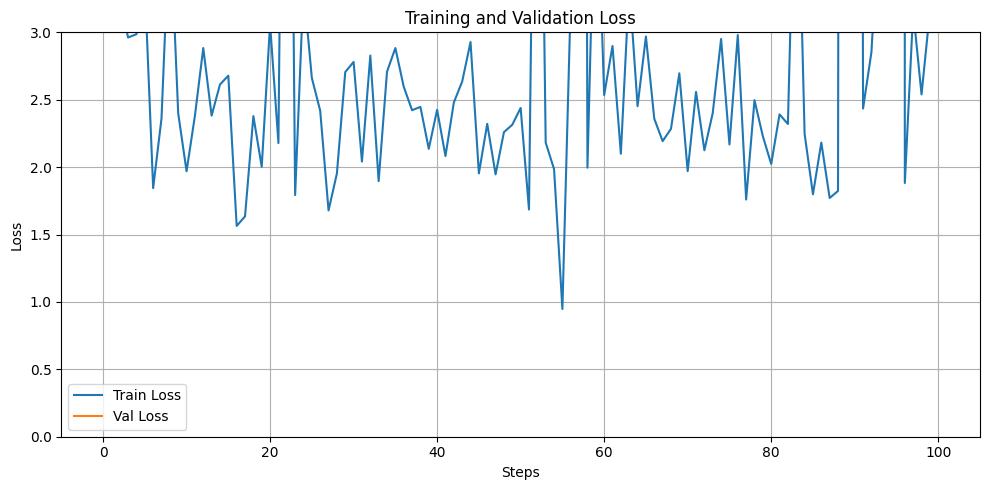

Step 101/1000, Loss: 2.9044
Step 102/1000, Loss: 3.1285
Step 103/1000, Loss: 2.4170
Step 104/1000, Loss: 2.4910
Step 105/1000, Loss: 2.8710
Step 106/1000, Loss: 3.1304
Step 107/1000, Loss: 2.6397
Step 108/1000, Loss: 2.3114
Step 109/1000, Loss: 2.4866
Step 110/1000, Loss: 2.7839
Step 111/1000, Loss: 2.3212
Step 112/1000, Loss: 2.0915
Step 113/1000, Loss: 35.9083
Step 114/1000, Loss: 2.5053
Step 115/1000, Loss: 2.1414
Step 116/1000, Loss: 2.9648
Step 117/1000, Loss: 153.2257
Step 118/1000, Loss: 122.5703
Step 119/1000, Loss: 6.9447
Step 120/1000, Loss: 5.1345
Step 121/1000, Loss: 5.7772
Step 122/1000, Loss: 5.7445
Step 123/1000, Loss: 5.4187
Step 124/1000, Loss: 5.0302
Step 125/1000, Loss: 4.7209
Step 126/1000, Loss: 4.5081
Step 127/1000, Loss: 4.8164
Step 128/1000, Loss: 4.6811
Step 129/1000, Loss: 4.5569
Step 130/1000, Loss: 4.6392
Step 131/1000, Loss: 4.6987
Step 132/1000, Loss: 4.8867
Step 133/1000, Loss: 4.6533
Step 134/1000, Loss: 4.5328
Step 135/1000, Loss: 4.3220
Step 136/1000, 

  0%|          | 0/263 [00:00<?, ?it/s]

[Eval at step 200] Val Loss: 5.5605


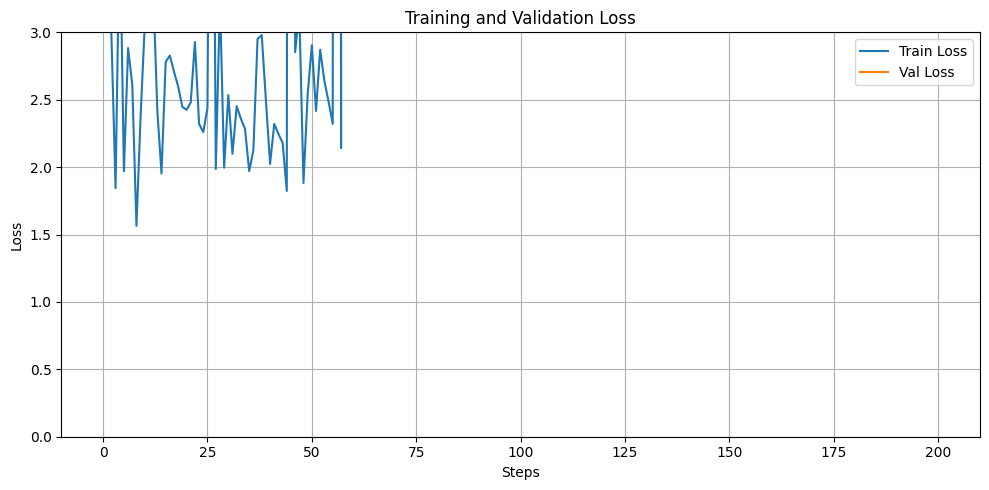

Step 201/1000, Loss: 4.3400
Step 202/1000, Loss: 4.2810
Step 203/1000, Loss: 4.3724
Step 204/1000, Loss: 4.2403
Step 205/1000, Loss: 4.2529
Step 206/1000, Loss: 4.3290
Step 207/1000, Loss: 4.4955
Step 208/1000, Loss: 4.3536
Step 209/1000, Loss: 4.3251
Step 210/1000, Loss: 67.8426
Step 211/1000, Loss: 4.5665
Step 212/1000, Loss: 4.3994
Step 213/1000, Loss: 4.3559
Step 214/1000, Loss: 4.4021
Step 215/1000, Loss: 4.4337
Step 216/1000, Loss: 26.6376
Step 217/1000, Loss: 4.6364
Step 218/1000, Loss: 4.4278
Step 219/1000, Loss: 4.4374
Step 220/1000, Loss: 4.4348
Step 221/1000, Loss: 4.5824
Step 222/1000, Loss: 4.5504
Step 223/1000, Loss: 4.5483
Step 224/1000, Loss: 4.4290
Step 225/1000, Loss: 4.2394
Step 226/1000, Loss: 4.2976
Step 227/1000, Loss: 4.3568
Step 228/1000, Loss: 4.3794
Step 229/1000, Loss: 4.3986
Step 230/1000, Loss: 4.3433
Step 231/1000, Loss: 4.5907
Step 232/1000, Loss: 45.9385
Step 233/1000, Loss: 4.3157
Step 234/1000, Loss: 4.4138
Step 235/1000, Loss: 5.6666
Step 236/1000, Lo

  0%|          | 0/263 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm


model.config.use_cache = False
model.config.pretraining_tp = 1
gradient_accumulation_steps = 4
max_steps=1000
max_loss = 1e9

# Track losses
train_losses = []
running_train_loss=[]
val_losses = []
steps = []
val_steps=[]

# Define optimizer
params_to_optimize = list(filter(lambda p: p.requires_grad, model.parameters()))
optimizer = Adam8bit(params_to_optimize, lr=1e-4)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=max_steps,
)
# Training loop
model.train()

global_step= 0

while global_step< max_steps:
    for step,batch in enumerate(train_dataloader):
        model.config.use_cache = False
        model.train()
        
        # Forward pass
        outputs = model(input_ids=batch['input_ids'].to('cuda'), attention_mask=batch['attention_mask'].to('cuda'), labels=batch['labels'].to('cuda'))
        loss = outputs.loss
        running_train_loss.append(loss.item())
        # loss = loss / gradient_accumulation_steps  # Normalize loss
        loss.backward()
        
        # if (step + 1) % gradient_accumulation_steps == 0:
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        global_step += 1
        if global_step >= max_steps:
            break
        
        print(f"Step {global_step}/{max_steps}, Loss: {loss.item():.4f}")

        if global_step % 100 == 0:
            flush()
            # Store train loss
            train_losses.append(np.mean(running_train_loss[-20:]))
            steps.append(global_step)

            # Evaluate on validation set
            model.eval()
            total_val_loss = 0
            count = 0
            with torch.no_grad():
                pbar = tqdm(test_dataloader, total=len(test_dataloader), leave=True)
                for val_batch in pbar:
                    val_outputs = model(
                        input_ids=val_batch['input_ids'].to('cuda'),
                        attention_mask=val_batch['attention_mask'].to('cuda'),
                        labels=val_batch['labels'].to('cuda')
                    )
                    total_val_loss += val_outputs.loss.item()
                    count += 1
                    pbar.set_postfix({'val_loss': f'{(total_val_loss / count):.4f}'})
            avg_val_loss = total_val_loss / count
            val_losses.append(avg_val_loss)
            val_steps.append(global_step)
            print(f"[Eval at step {global_step}] Val Loss: {avg_val_loss:.4f}")
            model.train()
            # Plotting losses
            plt.figure(figsize=(10, 5))
            plt.plot(running_train_loss[::len(val_steps)], label='Train Loss')
            plt.plot(val_steps, val_losses, label='Val Loss')
            plt.ylim([0,3])
            plt.xlabel('Steps')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig("train_val_loss_plot.png")
            plt.show()
            
        # if global_step % 20 == 0:
        #     pred = generate_eval(model=model,idx=40,disable_lora=False)
        #     print('*'*20,step+1,'*'*20)
        #     print("Predictions:", pred)
        #     print('*'*20,'end','*'*20)
            
        # if loss.item() < max_loss:
        #     model.save_pretrained('/home/nas/buffer/mohan.dash/llama_3_finetuned/adapter')
        #     max_loss = loss.item()
                
         
flush()

In [23]:
pred = generate_eval(model=model,idx=40,disable_lora=False)
print('*'*20,step+1,'*'*20)
print("Predictions:", pred)
print('*'*20,'end','*'*20)

Attempting to cast a BatchEncoding to type torch.float16. This is not supported.


******************** 300 ********************
Predictions: <bos><bos><start_of_turn>user
ଭୁବନେଶ୍ୱରର ରାଜାରାଣୀ ମନ୍ଦିରର ଇତିହାସ କ’ଣ?<end_of_turn>
<start_of_turn>model
କୋରିମୟକ ପ୍ର୍ର ଆ, ପରଚପୋକଷନ୍ ନତଚରା ପ୍ରେଲୋମ<end_of_turn>
******************** end ********************


# Loading the LoRA and saving the Adapter

In [ ]:
# model_with_adapter.save_pretrained('/home/nas/buffer/mohan.dash/llama_3_finetuned/adapter')

In [7]:
# Load the adapter into the base model
model = PeftModel.from_pretrained(model, '/home/nas/buffer/mohan.dash/llama_3_finetuned/adapter')
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072)
        (layers): ModuleList(
          (0-27): 28 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj):

In [10]:
pred = generate_eval(model,idx=40,disable_lora=False)
print(pred)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|><|begin_of_text|> <|start_header_id|>user<|end_header_id|>

ଭୁବନେଶ୍ୱରର ରାଜାରାଣୀ ମନ୍ଦିରର ଇତିହାସ କ’ଣ?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ପୂର୍ବ-ଗୋଟିଏ ଖୈଳଧଙ୍ଚ, ଯେଉଁଠି ଅଂଘାଡ଼ି ସୃଷ୍ଟି ଥିଲା। ଆଞ୍ଚଳିକ ସୌନ୍ଦର୍ଯ୍ୟ ସଫର କରିଛି, ଓ ସ୍ଥାନୀୟ ଔପନିବେଶକମାନେ ପ୍ରଵେଶ କରୁଛନ୍ତି।
" " - ଢ. ପ୍ରୋଫେସର ଐ. ରେନି (1928) | ଏହା ତ୍ରୟୋଦଶ ଶତାବ୍ଦୀରେ ସମ୍ପର୍କିତ ଏକ ଜାରିବାର ପାଳନ କରୁଛି । ରାଜାରାଣୀ ଦୁ


In [ ]:
# Path to your saved checkpoint
save_path = "/home/nas/buffer/mohan.dash/llama_3_finetuned/model_checkpoint.pt"

# Load checkpoint
checkpoint = torch.load(save_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')

# Restore model, optimizer, scheduler, and step
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
global_step = checkpoint['global_step']

# print(f"Checkpoint loaded from {save_path} at step {global_step}")

In [ ]:
checkpoint

In [ ]:
global_step = checkpoint['global_step']

In [ ]:
global_step

: 

In [ ]:
save_path = "/home/nas/buffer/mohan.dash/llama_3_finetuned/model_checkpoint.pt"

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'global_step': global_step
}, save_path)

print(f"Checkpoint saved to {save_path}")